# <u> Web Scarping <u> 

### Importing Libraries and defining Variables

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE_URL = "https://books.toscrape.com/"
MAX_ROWS = 1000

titles, prices, categories, ratings, reviews = [], [], [], [], []


Importing relevant libraries for importing webdata and assigning it to a variable.

### Rating Extraction

In [2]:
def get_rating(star_tag):
    classes = star_tag.get("class", [])
    for c in classes:
        if c in ["One", "Two", "Three", "Four", "Five"]:
            return c
    return None


we use this function because the rating is not written as normal text on the page, it is stored inside the HTML class name.

### Category Extraction

In [3]:
response = requests.get(BASE_URL)
soup = BeautifulSoup(response.text, "html.parser")

category_links = soup.select("div.side_categories ul li ul li a")

category_data = []
for a in category_links:
    cat_name = a.text.strip()
    cat_url = BASE_URL + a.get("href")
    category_data.append((cat_name, cat_url))

print(f"Found {len(category_data)} categories")


Found 50 categories


This code opens the homepage, extracts all category links, stores each category name with its URL in a list, and finally prints the total number of categories found

### Scraping Data Based on Category

In [4]:
for cat_name, cat_url in category_data:
    if len(titles) >= MAX_ROWS:
        break

    print(f"\nScraping category: {cat_name}")

    page_url = cat_url

    while page_url and len(titles) < MAX_ROWS:
        res = requests.get(page_url)
        soup = BeautifulSoup(res.text, "html.parser")

        products = soup.select("article.product_pod")

        for p in products:
            if len(titles) >= MAX_ROWS:
                break

            title = p.h3.a["title"]
            price = p.select_one("p.price_color").text.strip()
            rating = get_rating(p.select_one("p.star-rating"))

            # Reviews not present on this website → set 0
            review_count = 0

            titles.append(title)
            prices.append(price)
            categories.append(cat_name)
            ratings.append(rating)
            reviews.append(review_count)

        # Pagination next button
        next_btn = soup.select_one("li.next a")
        if next_btn:
            next_page = next_btn.get("href")
            page_url = page_url.rsplit("/", 1)[0] + "/" + next_page
        else:
            page_url = None

        time.sleep(0.3)



Scraping category: Travel

Scraping category: Mystery

Scraping category: Historical Fiction

Scraping category: Sequential Art

Scraping category: Classics

Scraping category: Philosophy

Scraping category: Romance

Scraping category: Womens Fiction

Scraping category: Fiction

Scraping category: Childrens

Scraping category: Religion

Scraping category: Nonfiction

Scraping category: Music

Scraping category: Default

Scraping category: Science Fiction

Scraping category: Sports and Games

Scraping category: Add a comment

Scraping category: Fantasy

Scraping category: New Adult

Scraping category: Young Adult

Scraping category: Science

Scraping category: Poetry

Scraping category: Paranormal

Scraping category: Art

Scraping category: Psychology

Scraping category: Autobiography

Scraping category: Parenting

Scraping category: Adult Fiction

Scraping category: Humor

Scraping category: Horror

Scraping category: History

Scraping category: Food and Drink

Scraping category: Chri

This code loops through each category one by one, scrapes all the books available in that category, and keeps moving page by page using the “Next” button until there are no more pages or the dataset reaches 1000 rows. Finally, it stores the scraped details into separate lists so they can be combined later to build a complete dataset.

### Creating Dataframe and Saving Data

In [5]:
df = pd.DataFrame({
    "Product Name": titles,
    "Price": prices,
    "Category": categories,
    "Rating": ratings,
    "Number of Reviews": reviews
})

print("\nTotal scraped rows:", len(df))
print(df.head())
df.to_csv("books_multicategory_final.csv", index=False)
print("\nSaved file as books_multicategory_final.csv")



Total scraped rows: 1000
                                        Product Name    Price Category Rating  \
0                            It's Only the Himalayas  Â£45.17   Travel    Two   
1  Full Moon over Noahâs Ark: An Odyssey to Mou...  Â£49.43   Travel   Four   
2  See America: A Celebration of Our National Par...  Â£48.87   Travel  Three   
3  Vagabonding: An Uncommon Guide to the Art of L...  Â£36.94   Travel    Two   
4                               Under the Tuscan Sun  Â£37.33   Travel  Three   

   Number of Reviews  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

Saved file as books_multicategory_final.csv


Creating a dataframe out of the extracted data and saving it.

# <u> Data Cleaning <u> 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product Name       1000 non-null   object
 1   Price              1000 non-null   object
 2   Category           1000 non-null   object
 3   Rating             1000 non-null   object
 4   Number of Reviews  1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [7]:
df["Price"] = (df["Price"].str.replace(r"[^\d.]", "", regex=True).astype(float))

In [8]:
rating_map = {
    "One": 1,
    "Two": 2,
    "Three": 3,
    "Four": 4,
    "Five": 5
}

df["Rating"] = df["Rating"].map(rating_map)

In [9]:
df["Number of Reviews"] = df["Number of Reviews"].astype(int)


In [10]:
df.isna().sum()

Product Name         0
Price                0
Category             0
Rating               0
Number of Reviews    0
dtype: int64

In [11]:
df.drop_duplicates(inplace=True)


In [12]:
print("Total rows:", len(df))
print(df.describe())

print(df["Category"].value_counts().head())


Total rows: 1000
            Price       Rating  Number of Reviews
count  1000.00000  1000.000000             1000.0
mean     35.07035     2.923000                0.0
std      14.44669     1.434967                0.0
min      10.00000     1.000000                0.0
25%      22.10750     2.000000                0.0
50%      35.98000     3.000000                0.0
75%      47.45750     4.000000                0.0
max      59.99000     5.000000                0.0
Category
Default           152
Nonfiction        110
Sequential Art     75
Add a comment      67
Fiction            65
Name: count, dtype: int64


In [13]:
df.drop(columns=["Number of Reviews"], inplace=True)


In [14]:
df.columns


Index(['Product Name', 'Price', 'Category', 'Rating'], dtype='object')

1. keeping only the price and removing the currencies and changing it to float.
2. Mapping the star ratings to numbers.
3. Removing the column Number of Reviews as it doesn't contain any value.

# <u> Exploratory Data Analysis <u> 

In [15]:
df["Category"].value_counts()

Category
Default               152
Nonfiction            110
Sequential Art         75
Add a comment          67
Fiction                65
Young Adult            54
Fantasy                48
Romance                35
Mystery                32
Food and Drink         30
Childrens              29
Historical Fiction     26
Poetry                 19
Classics               19
History                18
Womens Fiction         17
Horror                 17
Science Fiction        16
Science                14
Music                  13
Business               12
Travel                 11
Thriller               11
Philosophy             11
Humor                  10
Autobiography           9
Art                     8
Religion                7
Psychology              7
Spirituality            6
New Adult               6
Christian Fiction       6
Self Help               5
Sports and Games        5
Biography               5
Health                  4
Contemporary            3
Christian               3
Pol

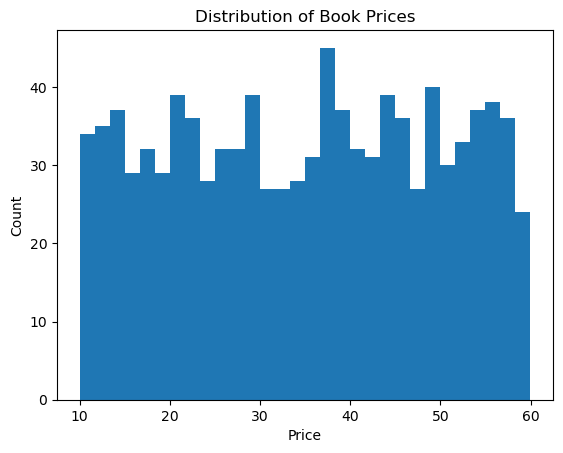

In [16]:
import matplotlib.pyplot as plt

plt.hist(df["Price"], bins=30)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Book Prices")
plt.show()


In [17]:
df["Rating"].value_counts().sort_index()


Rating
1    226
2    196
3    203
4    179
5    196
Name: count, dtype: int64

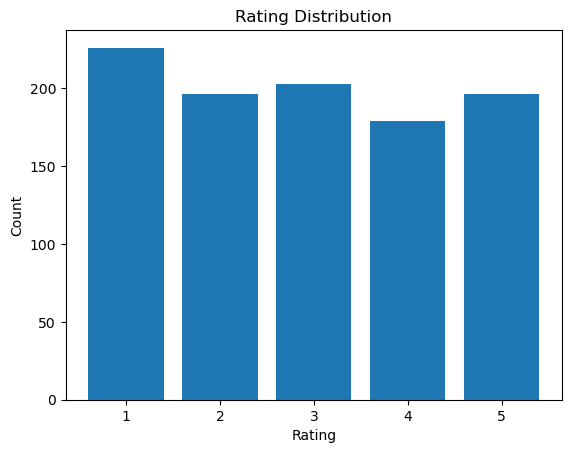

In [18]:
plt.bar(df["Rating"].value_counts().index, df["Rating"].value_counts().values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()


1. Book prices are widely distributed across the range, indicating the presence of both low-priced and premium books in the dataset.
2. There is no strong price concentration, suggesting a relatively balanced pricing strategy across products.
3. Ratings are fairly evenly distributed from 1 to 5, with no extreme skew toward only high or low ratings.
4. The presence of all rating levels indicates diverse customer satisfaction levels across categories.

# <u> Unsupervised Learning <u> 

# K-Means Clustering 

In [19]:
X = df[["Price", "Rating"]]

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [21]:
from sklearn.metrics import silhouette_score


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

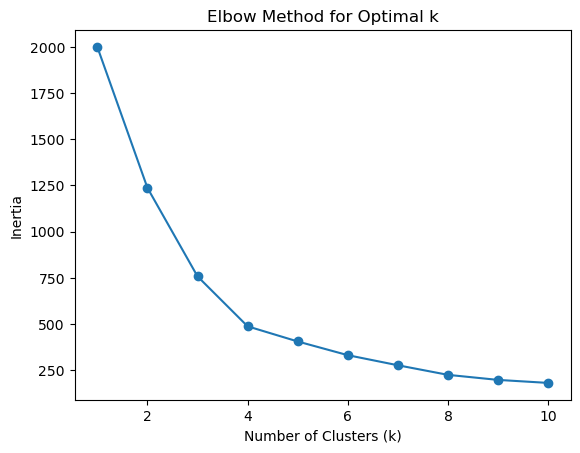

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [23]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)


In [24]:
sil_score = silhouette_score(X_scaled, df["Cluster"])
print("Silhouette Score:", sil_score)


Silhouette Score: 0.42873582745443445


In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
df.groupby("Cluster")[["Price", "Rating"]].mean()


,Price,Rating
Cluster,,
0,21.464963,3.918519
1,47.535844,4.048701
2,22.026162,1.444444
3,45.859777,1.482143


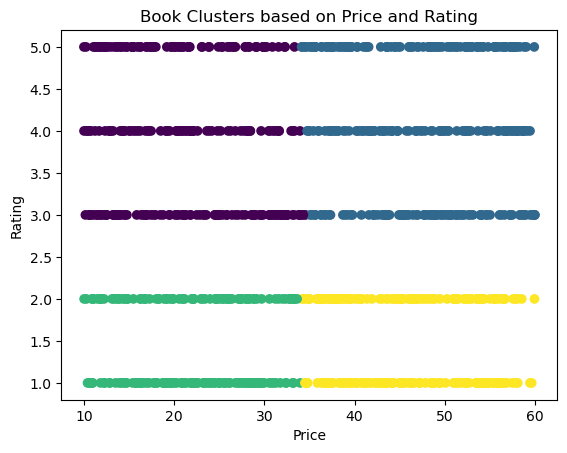

In [27]:
plt.scatter(df["Price"], df["Rating"], c=df["Cluster"])
plt.xlabel("Price")
plt.ylabel("Rating")
plt.title("Book Clusters based on Price and Rating")
plt.show()


K-Means clustering was applied to discover natural groupings in the product data. The elbow method indicated a noticeable reduction in inertia at four clusters, suggesting an optimal clustering structure. Additionally, the silhouette score of 0.428 confirmed that the resulting clusters were reasonably well-separated and meaningful.

# <u> Feature Scaling <u> 

In [28]:
df["Category"].value_counts()


Category
Default               152
Nonfiction            110
Sequential Art         75
Add a comment          67
Fiction                65
Young Adult            54
Fantasy                48
Romance                35
Mystery                32
Food and Drink         30
Childrens              29
Historical Fiction     26
Poetry                 19
Classics               19
History                18
Womens Fiction         17
Horror                 17
Science Fiction        16
Science                14
Music                  13
Business               12
Travel                 11
Thriller               11
Philosophy             11
Humor                  10
Autobiography           9
Art                     8
Religion                7
Psychology              7
Spirituality            6
New Adult               6
Christian Fiction       6
Self Help               5
Sports and Games        5
Biography               5
Health                  4
Contemporary            3
Christian               3
Pol

In [29]:
df["Rating_cat"] = df["Rating"].astype(str)


In [30]:
from sklearn.preprocessing import LabelEncoder

le_cat = LabelEncoder()
df["Category_enc"] = le_cat.fit_transform(df["Category"])


In [31]:
X = df[["Price", "Category_enc"]]
y = df["Rating_cat"]


In [32]:
from sklearn.model_selection import train_test_split

X_train_str, X_test_str, y_train_str, y_test_str = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_str)
X_test_scaled = scaler.transform(X_test_str)


Using Price and encoded category as predictive power for rating, especially encoding category as and also converting rating as category.

# <u> Supervised Learning <u>

# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_str)

y_pred_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test_str, y_pred_lr))
print("Logistic Regression F1 Score:", f1_score(y_test_str, y_pred_lr, average="weighted"))


Logistic Regression Accuracy: 0.21
Logistic Regression F1 Score: 0.13754667824576639


# Support Vector Machine (SVM)

In [35]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", random_state=42)
svm.fit(X_train_scaled, y_train_str)

y_pred_svm = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test_str, y_pred_svm))
print("SVM F1 Score:", f1_score(y_test_str, y_pred_svm, average="weighted"))


SVM Accuracy: 0.19
SVM F1 Score: 0.16899919327918106


# k-Nearest Neighbors (KNN)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_str)

y_pred_knn = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test_str, y_pred_knn))
print("KNN F1 Score:", f1_score(y_test_str, y_pred_knn, average="weighted"))


KNN Accuracy: 0.195
KNN F1 Score: 0.1914992728521


# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_str, y_train_str)

y_pred_rf = rf.predict(X_test_str)

print("Random Forest Accuracy:", accuracy_score(y_test_str, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test_str, y_pred_rf, average="weighted"))


Random Forest Accuracy: 0.175
Random Forest F1 Score: 0.1737949608668703


# XGBoost

In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(df["Rating_cat"])


In [44]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)



In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = xgb.predict(X_test_xgb)

print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("XGBoost F1 Score:", f1_score(y_test_xgb, y_pred_xgb, average="weighted"))


XGBoost Accuracy: 0.185
XGBoost F1 Score: 0.18190028147027834


In [46]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "SVM",
        "KNN",
        "Random Forest",
        "XGBoost"
    ],
    "Accuracy": [
        accuracy_score(y_test_str, y_pred_lr),
        accuracy_score(y_test_str, y_pred_svm),
        accuracy_score(y_test_str, y_pred_knn),
        accuracy_score(y_test_str, y_pred_rf),
        accuracy_score(y_test_xgb, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test_str, y_pred_lr, average="weighted"),
        f1_score(y_test_str, y_pred_svm, average="weighted"),
        f1_score(y_test_str, y_pred_knn, average="weighted"),
        f1_score(y_test_str, y_pred_rf, average="weighted"),
        f1_score(y_test_xgb, y_pred_xgb, average="weighted")
    ]
})

results


,Model,Accuracy,F1 Score
0,Logistic Regression,0.210,0.137547
1,SVM,0.190,0.168999
2,KNN,0.195,0.191499
3,Random Forest,0.175,0.173795
4,XGBoost,0.185,0.181900


KNN demonstrated relatively better class balance, while Logistic Regression showed higher overall accuracy but weaker F1 performance. These results highlight the importance of richer feature selection.

# <u> Hyper Paramater Tuning <u>

In [47]:
from sklearn.model_selection import GridSearchCV


In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11]
}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(
    knn,
    knn_params,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

knn_grid.fit(X_train_scaled, y_train_str)

print("Best KNN Parameters:", knn_grid.best_params_)
print("Best KNN CV F1 Score:", knn_grid.best_score_)


Best KNN Parameters: {'n_neighbors': 9}
Best KNN CV F1 Score: 0.2233816028147837


In [49]:
from sklearn.svm import SVC

svm_params = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.1],
    "kernel": ["rbf"]
}

svm = SVC()

svm_grid = GridSearchCV(
    svm,
    svm_params,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

svm_grid.fit(X_train_scaled, y_train_str)

print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM CV F1 Score:", svm_grid.best_score_)


Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM CV F1 Score: 0.19529737246963158


In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

rf_grid.fit(X_train_str, y_train_str)

print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF CV F1 Score:", rf_grid.best_score_)


Best RF Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV F1 Score: 0.233467340290124


In [51]:
best_knn = knn_grid.best_estimator_
y_pred_knn_tuned = best_knn.predict(X_test_scaled)

print("Tuned KNN Accuracy:", accuracy_score(y_test_str, y_pred_knn_tuned))
print("Tuned KNN F1 Score:", f1_score(y_test_str, y_pred_knn_tuned, average="weighted"))


Tuned KNN Accuracy: 0.2
Tuned KNN F1 Score: 0.19408305285541055


In [52]:
best_svm = svm_grid.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test_scaled)

print("Tuned SVM Accuracy:", accuracy_score(y_test_str, y_pred_svm_tuned))
print("Tuned SVM F1 Score:", f1_score(y_test_str, y_pred_svm_tuned, average="weighted"))


Tuned SVM Accuracy: 0.22
Tuned SVM F1 Score: 0.21166808919236105


In [53]:
best_rf = rf_grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_str)

print("Tuned RF Accuracy:", accuracy_score(y_test_str, y_pred_rf_tuned))
print("Tuned RF F1 Score:", f1_score(y_test_str, y_pred_rf_tuned, average="weighted"))


Tuned RF Accuracy: 0.18
Tuned RF F1 Score: 0.17704886487986068


In [54]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

comparison = pd.DataFrame({
    "Model": [
        "KNN",
        "SVM",
        "Random Forest"
    ],
    "Accuracy (Before)": [
        accuracy_score(y_test_str, y_pred_knn),
        accuracy_score(y_test_str, y_pred_svm),
        accuracy_score(y_test_str, y_pred_rf)
    ],
    "Accuracy (After)": [
        accuracy_score(y_test_str, y_pred_knn_tuned),
        accuracy_score(y_test_str, y_pred_svm_tuned),
        accuracy_score(y_test_str, y_pred_rf_tuned)
    ],
    "F1 Score (Before)": [
        f1_score(y_test_str, y_pred_knn, average="weighted"),
        f1_score(y_test_str, y_pred_svm, average="weighted"),
        f1_score(y_test_str, y_pred_rf, average="weighted")
    ],
    "F1 Score (After)": [
        f1_score(y_test_str, y_pred_knn_tuned, average="weighted"),
        f1_score(y_test_str, y_pred_svm_tuned, average="weighted"),
        f1_score(y_test_str, y_pred_rf_tuned, average="weighted")
    ]
})

comparison


,Model,Accuracy (Before),Accuracy (After),F1 Score (Before),F1 Score (After)
0,KNN,0.195,0.20,0.191499,0.194083
1,SVM,0.190,0.22,0.168999,0.211668
2,Random Forest,0.175,0.18,0.173795,0.177049


Model performance remained modest across all algorithms, indicating that price and category alone were insufficient predictors of rating. Hyperparameter tuning improved model stability, particularly for SVM, but feature limitations restricted overall predictive power.

The available features had limited predictive power. Ratings are influenced by subjective factors such as reader perception, which cannot be captured solely by price and category.

# <u> Conclusion <u>

The project demonstrated that unsupervised learning was effective in identifying natural groupings within the dataset based on price and rating. 

•	K-Means clustering revealed meaningful segments, suggesting that these features capture general patterns in product positioning. 

•	However, supervised learning models showed limited success in predicting product categories, indicating that price and rating alone are weak predictors of labelled outcomes. The contrast between the two approaches highlights that while the data contains inherent structure, the selected features were insufficient for accurate classification.
